# Introduction:

Cataracts are a clouding of the lens in the eye that can cause blurred vision. They are the leading cause of blindness in the world. Cataract classification is the process of automatically identifying cataracts in eye images. This can be used to help doctors diagnose cataracts and to develop new treatments.
<br>
<br>
In this project, we will use EfficientNet to build a model for cataract classification. EfficientNet is a family of convolutional neural networks that are designed to be efficient and accurate. We will use the EfficientNet-B0 model, which is a small but powerful model that can be trained on a variety of datasets.
<br>
<br>
We will train our model on a dataset of eye images that have been labeled as either having cataracts or not having cataracts. We will then evaluate the performance of our model on a separate dataset of test images.
<br>
<br>
We expect that our model will be able to classify cataracts with high accuracy. This will help to improve the diagnosis of cataracts and to develop new treatments.

**Steps involved in the project:**

---



1.   Import the necessary libraries.
2. Set the configurations and read the metadata.
3. Process the Cataract dataset.
4. Process the Ocular disease recognition dataset.
5. Merge the 2 datasets.
6. Build the model.
7. Train the model.
8. Evaluate the model.

## 1. Import the necessary libraries.

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json /root/.kaggle/

import os
for filename in os.listdir('/content'):
    print(filename)

# Set the permissions for the kaggle.json file to make it readable only by the owner
!chmod 777 /root/.kaggle

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

!unzip ocular-disease-recognition-odir5k.zip

In [ ]:
!kaggle datasets download -d jr2ngb/cataractdataset

!unzip cataractdataset.zip

In [ ]:
!pip install -q efficientnet

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob, cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn

from tqdm import tqdm

## 2. Set the configurations and read the metadata.

In [6]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 64
IMG_HEIGHT = 192
IMG_WIDTH = 256

# reading the cataract dataset
IMG_ROOT = '/content/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal',
           IMG_ROOT+'2_cataract',
           IMG_ROOT+'2_glaucoma',
           IMG_ROOT+'3_retina_disease']

# reading the ocular-disease-recognition dataset
OCU_IMG_ROOT = '/content/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('/content/ODIR-5K/ODIR-5K/data.xlsx')

The function below, seed_everything() sets the seed for all random number generators used in Python, NumPy, and TensorFlow. This ensures that the results of the function are reproducible, regardless of how many times it is called or on which machine it is run.

In [7]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## 3. Process the Cataract dataset.

This code works by first creating a list of all the filepaths in the Cataract dataset.  The paths column contains the full filepaths, and the cataract column contains the class labels (0 for normal and 1 for cataract). Finally, the code uses the query() method to filter the DataFrame to only include images with class labels 0 or 1.

In [10]:
cataract_data = pd.DataFrame(columns=['paths', 'cataract'])

filepaths = glob.glob(IMG_ROOT + '*/*')

for i, filepath in enumerate(filepaths):
    path_parts = os.path.split(filepath)
    cataract_data.loc[i] = [path_parts[0] + '/' + path_parts[1],
                     IMG_DIR.index(path_parts[0]) if path_parts[0] in IMG_DIR else None]

cataract_data = cataract_data.query('0 <= cataract < 2')

print(cataract_data)

                                            paths  cataract
101  /content/dataset/2_cataract/cataract_002.png         1
102  /content/dataset/2_cataract/cataract_050.png         1
103  /content/dataset/2_cataract/cataract_035.png         1
104  /content/dataset/2_cataract/cataract_085.png         1
105  /content/dataset/2_cataract/cataract_053.png         1
..                                            ...       ...
496          /content/dataset/1_normal/NL_234.png         0
497          /content/dataset/1_normal/NL_014.png         0
498          /content/dataset/1_normal/NL_149.png         0
499          /content/dataset/1_normal/NL_102.png         0
500          /content/dataset/1_normal/NL_287.png         0

[400 rows x 2 columns]


In [11]:
print('Number of normal and cataract images')
print(cataract_data['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


## 4. Process the Ocular disease recognition dataset.

In [12]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


This dataset looks different from the previous one. The columns "Left-Dianostic Keywords" and "Right-Diagnostic Keywords" have the keyword "cataract". We will extract the same to convert them into "Has Cataract" and "Don't have cataract" values.

In [13]:
def has_cataract_mentioned(text):
    return int('cataract' in text)

ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords'].apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords'].apply(lambda x: has_cataract_mentioned(x))

le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']].rename(columns={'left_eye_cataract': 'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)

re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']].rename(columns={'right_eye_cataract': 'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [14]:
le_df.head()

,cataract,paths
0,1,/content/ODIR-5K/ODIR-5K/Training Images/0_lef...
1,0,/content/ODIR-5K/ODIR-5K/Training Images/1_lef...
2,0,/content/ODIR-5K/ODIR-5K/Training Images/2_lef...
3,0,/content/ODIR-5K/ODIR-5K/Training Images/3_lef...
4,0,/content/ODIR-5K/ODIR-5K/Training Images/4_lef...


In [15]:
re_df.head()

,cataract,paths
0,0,/content/ODIR-5K/ODIR-5K/Training Images/0_rig...
1,0,/content/ODIR-5K/ODIR-5K/Training Images/1_rig...
2,0,/content/ODIR-5K/ODIR-5K/Training Images/2_rig...
3,0,/content/ODIR-5K/ODIR-5K/Training Images/3_rig...
4,0,/content/ODIR-5K/ODIR-5K/Training Images/4_rig...


In [16]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


Clearly, the dataset has large bias. We'll need to make it even.

In [18]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']),
                                       random_state=SEED)
    ])
    return df

le_df = re_df = downsample(le_df)
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64
1    159
0    159
Name: cataract, dtype: int64


Perfect. Equal number of datasets. Let's merge them now.

In [19]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,/content/ODIR-5K/ODIR-5K/Training Images/0_lef...
81,1,/content/ODIR-5K/ODIR-5K/Training Images/81_le...
103,1,/content/ODIR-5K/ODIR-5K/Training Images/103_l...
119,1,/content/ODIR-5K/ODIR-5K/Training Images/119_l...
253,1,/content/ODIR-5K/ODIR-5K/Training Images/254_l...


## 5. Merge the 2 datasets.

In [20]:
final_df = pd.concat([cataract_data, ocu_df], ignore_index = True)
final_df

,paths,cataract
0,/content/dataset/2_cataract/cataract_002.png,1
1,/content/dataset/2_cataract/cataract_050.png,1
2,/content/dataset/2_cataract/cataract_035.png,1
3,/content/dataset/2_cataract/cataract_085.png,1
4,/content/dataset/2_cataract/cataract_053.png,1
...,...,...
1031,/content/ODIR-5K/ODIR-5K/Training Images/2680_...,0
1032,/content/ODIR-5K/ODIR-5K/Training Images/328_l...,0
1033,/content/ODIR-5K/ODIR-5K/Training Images/1564_...,0
1034,/content/ODIR-5K/ODIR-5K/Training Images/3052_...,0


## 6. Building the Model.

In [21]:
train_df, test_df = train_test_split(final_df,
                                     test_size = 0.2,
                                     random_state = SEED,
                                     stratify = final_df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size = 0.15,
                                    random_state = SEED,
                                    stratify = train_df['cataract'])

In [22]:
def preprocess_image(img_path, img_width, img_height):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    return img

def create_datasets(df, img_width, img_height):
    imgs = np.array([preprocess_image(path, img_width, img_height) for path in tqdm(df['paths'])])
    df = pd.get_dummies(df['cataract'])
    return imgs, df

train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

100%|██████████| 208/208 [00:14<00:00, 14.23it/s]


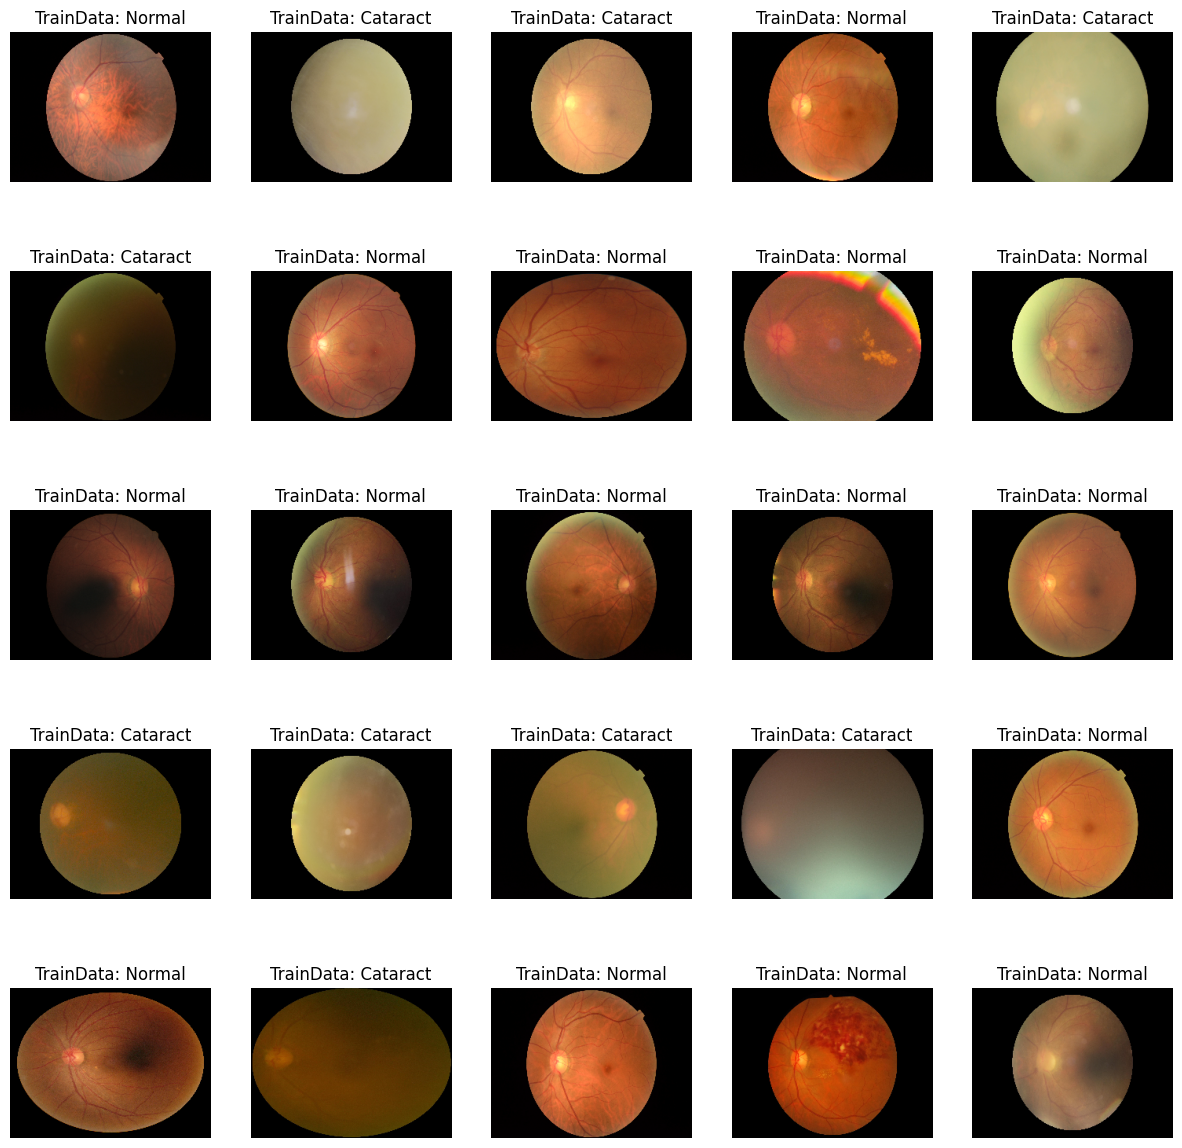

In [24]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])

for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')

plt.show()

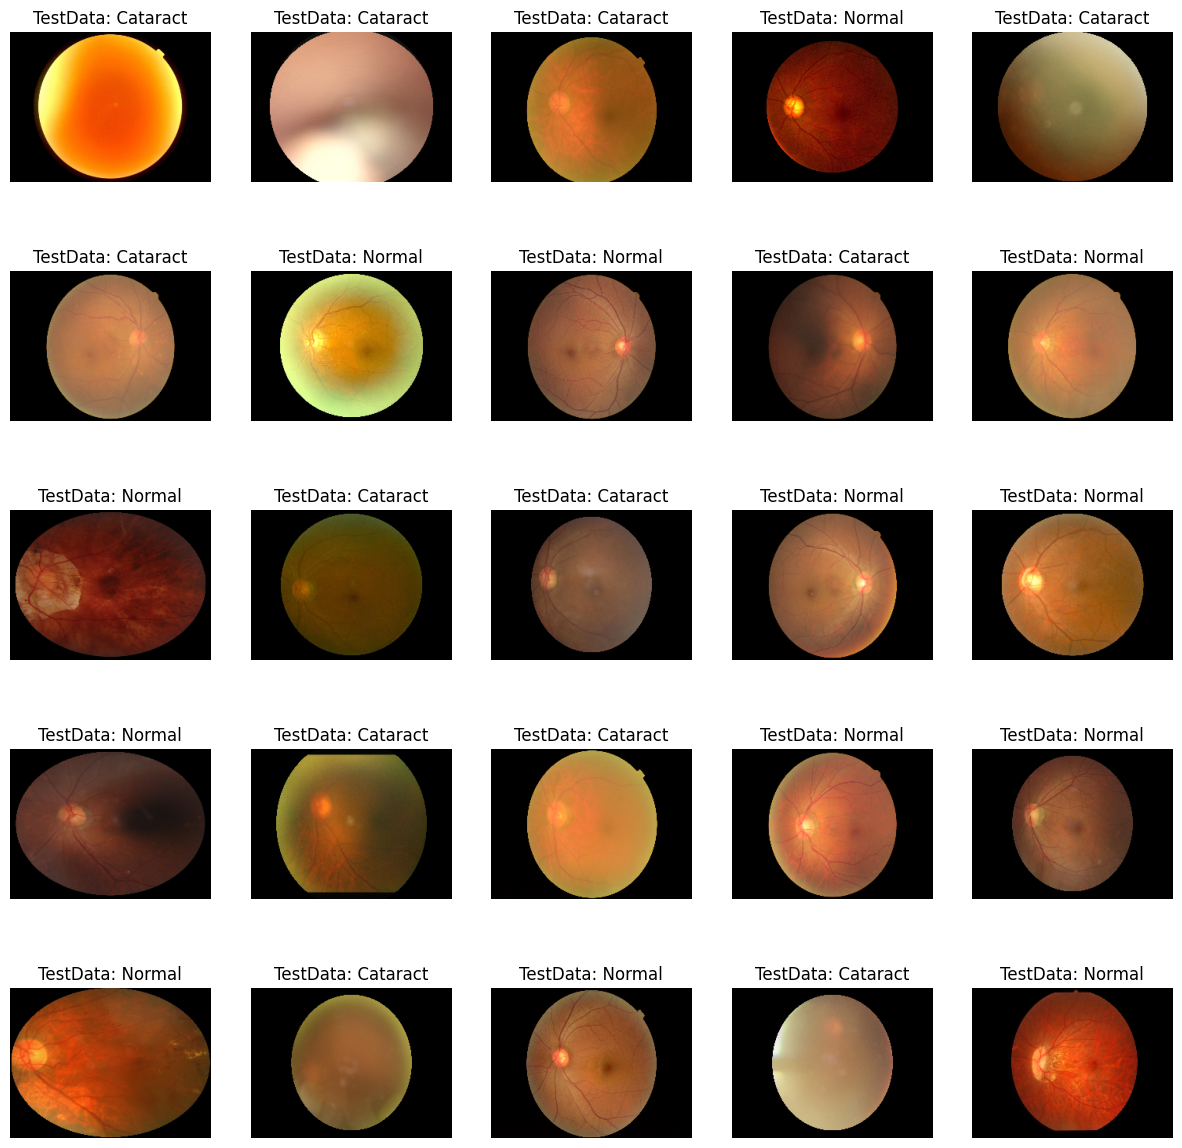

In [25]:
# plot the first 25 sheets of image data for Test

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])

for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')

plt.show()

In [28]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height, img_width, n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height, img_width, n),
        weights='imagenet',
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='sigmoid')(x)  # Use 'sigmoid' activation for binary classification
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)  # Use BinaryCrossentropy for binary classification
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 efficientnet-b0 (Functional  (None, 6, 8, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


Since we have two classes (Cataract and Normal), the final dense layer should have 2 units.

## 7. Train the model.

Epoch 1/100
10/10 [==============================] - 66s 2s/step - loss: 0.7159 - accuracy: 0.5064 - val_loss: 0.6812 - val_accuracy: 0.7120 - lr: 3.0000e-06
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.7017 - accuracy: 0.5747 - val_loss: 0.6583 - val_accuracy: 0.7840 - lr: 3.0000e-06
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 0.6928 - accuracy: 0.5903 - val_loss: 0.6532 - val_accuracy: 0.8000 - lr: 3.0000e-06
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 0.6680 - accuracy: 0.6814 - val_loss: 0.6537 - val_accuracy: 0.7920 - lr: 3.0000e-06
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 0.6590 - accuracy: 0.6899 - val_loss: 0.6555 - val_accuracy: 0.7680 - lr: 3.0000e-06
Epoch 6/100
10/10 [==============================] - 11s 993ms/step - loss: 0.6391 - accuracy: 0.7511 - val_loss: 0.6579 - val_accuracy: 0.7440 - lr: 3.0000e-06
Epoch 7/100
10/10 [==============================

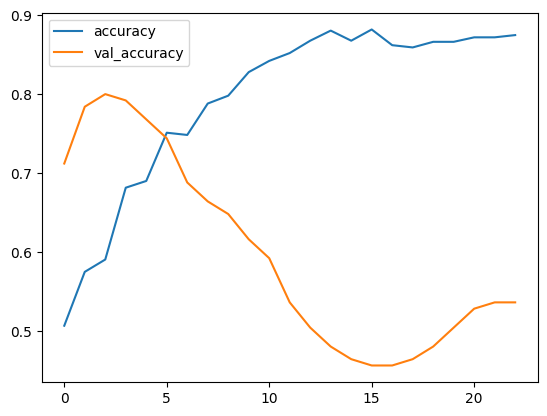

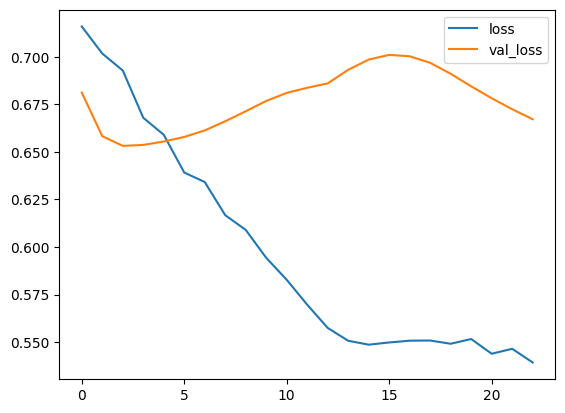

In [29]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')

es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10,
                                                 verbose=1)

history = model.fit(generator.flow(train_imgs, train_df, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

# Plotting the training history
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

* The accuracy is slightly higher than the val_accuracy. This is because the model is overfitting to the training data. Overfitting occurs when the model learns the training data too well and is not able to generalize to new data.
<br>
* The accuracy and val_accuracy start to plateau after epoch 20. This means that the model is not learning as much as it was at the beginning of training.

Same is true for the 2nd graph also.

## 8. Evaluate the model.

In [30]:
model.evaluate(test_imgs, test_df)

7/7 [==============================] - 1s 174ms/step - loss: 0.6773 - accuracy: 0.7212


[0.6773139238357544, 0.7211538553237915]